# Setup

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
                             recall_score, f1_score, precision_recall_curve, average_precision_score)
from sklearn.ensemble import GradientBoostingClassifier

from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier

import itertools
import time

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/bank-additional-full.csv", sep=";")

# Data Preperation

In [ ]:
# Check if any variables have null values
print('Null value count:\n',df.isnull().sum())

# Check if any variables have 'unknown' values
print("\n'unknown' value count:")
print((df == 'unknown').sum())

# Check percentage of unknown values
unknown_percent = (df == 'unknown').sum() / len(df) * 100
unknown_percent = unknown_percent[unknown_percent > 0].sort_values(ascending=False)
print("\nPercentage of 'unknown' values:")
print(unknown_percent.round(2))

# default: drop
df = df.drop(columns=['default'])

Null value count:
 age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

'unknown' value count:
age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

Percentage of 'unknown' val

### Categorical Variables

In [ ]:
# job, marital, housing, loan, contact, poutcome: One-hot encoding
df = pd.get_dummies(df, columns=['job','marital','housing','loan','contact','poutcome'], drop_first=True)

# Convert boolean variables to numeric
for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(int)

# education: Label encoding with specified order
df['education'] = df['education'].map({'illiterate': 0, 'basic.4y': 1, 'basic.6y': 2, 'basic.9y': 3,
                                 'high.school': 4, 'professional.course': 5, 'university.degree': 6, 'unknown': 3})

### Date Variables

In [ ]:
# month: Label encoding with specified order
df['month'] = df['month'].map({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12})

# day_of_week: Label encoding with specified order
df['day_of_week'] = df['day_of_week'].map({'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5})

### Numeric Variables

In [ ]:
# duration: drop
df = df.drop(columns=['duration'])

print(df['pdays'].value_counts().sort_index())

# prev_contacted: create variable based on pdays value
df['prev_contacted'] = np.where(df['pdays'] == 999, 0, 1)

# pdays: drop
df = df.drop(columns=['pdays'])

pdays
0         15
1         26
2         61
3        439
4        118
5         46
6        412
7         60
8         18
9         64
10        52
11        28
12        58
13        36
14        20
15        24
16        11
17         8
18         7
19         3
20         1
21         2
22         3
25         1
26         1
27         1
999    39673
Name: count, dtype: int64


In [ ]:
# campaign_effort: derive from campaign and previous

df['campaign_effort'] = df['campaign'] / (df['previous'] + 1)

### Target Variable

In [ ]:
df['y'] = df['y'].map({'yes': 1, 'no': 0})

display(df)

,age,education,month,day_of_week,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,...,marital_unknown,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,poutcome_nonexistent,poutcome_success,prev_contacted,campaign_effort
0,56,1,5,1,1,0,1.1,93.994,-36.4,4.857,...,0,0,0,0,0,1,1,0,0,1.0
1,57,4,5,1,1,0,1.1,93.994,-36.4,4.857,...,0,0,0,0,0,1,1,0,0,1.0
2,37,4,5,1,1,0,1.1,93.994,-36.4,4.857,...,0,0,1,0,0,1,1,0,0,1.0
3,40,2,5,1,1,0,1.1,93.994,-36.4,4.857,...,0,0,0,0,0,1,1,0,0,1.0
4,56,4,5,1,1,0,1.1,93.994,-36.4,4.857,...,0,0,0,0,1,1,1,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,5,11,5,1,0,-1.1,94.767,-50.8,1.028,...,0,0,1,0,0,0,1,0,0,1.0
41184,46,5,11,5,1,0,-1.1,94.767,-50.8,1.028,...,0,0,0,0,0,0,1,0,0,1.0
41185,56,6,11,5,2,0,-1.1,94.767,-50.8,1.028,...,0,0,1,0,0,0,1,0,0,2.0
41186,44,5,11,5,1,0,-1.1,94.767,-50.8,1.028,...,0,0,0,0,0,0,1,0,0,1.0


### Train/Validation/Test

In [ ]:
# Predictor and target variables
X = df.drop(columns=['y'])
y = df['y']

# Split data 70/15/15 (train/valid/test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

# Decision Tree

In [ ]:
# Test out different parameters
param_grid = {
    'max_depth': [None, 3, 5, 7, 9, 12],
    'min_samples_split': [2, 5, 10, 20],
    'ccp_alpha': [0.0, 0.001, 0.01, 0.05]
}

dt = DecisionTreeClassifier(criterion='gini', random_state=42)

grid = GridSearchCV(
    dt,
    param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)

Best parameters: {'ccp_alpha': 0.0, 'max_depth': 5, 'min_samples_split': 2}


In [ ]:
# Tree with best parameters
dt = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    ccp_alpha=0,
    random_state=42)
dt.fit(X_train, y_train)

#y_pred = dt.predict(X_test)

y_train_pred = dt.predict(X_train)
y_valid_pred = dt.predict(X_valid)
y_test_pred  = dt.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
valid_acc = accuracy_score(y_valid, y_valid_pred)
test_acc  = accuracy_score(y_test,  y_test_pred)

print("Train Accuracy:",round(train_acc,3))
print("Validation Accuracy:",round(valid_acc,3))
print("Test Accuracy:",round(test_acc,3))

Train Accuracy: 0.903
Validation Accuracy: 0.899
Test Accuracy: 0.902


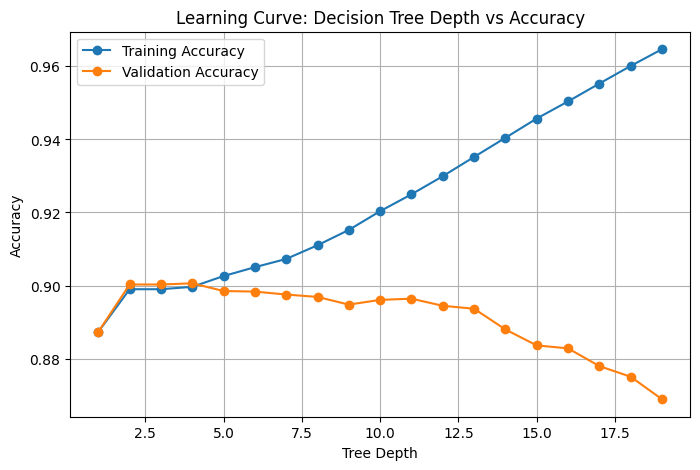

In [ ]:
depths = range(1, 20)
train_scores, valid_scores = [], []

for d in depths:
    dt = DecisionTreeClassifier(max_depth=d, random_state=42)
    dt.fit(X_train, y_train)
    train_scores.append(dt.score(X_train, y_train))
    valid_scores.append(dt.score(X_valid, y_valid))

plt.figure(figsize=(8,5))
plt.plot(depths, train_scores, label='Training Accuracy', marker='o')
plt.plot(depths, valid_scores, label='Validation Accuracy', marker='o')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Learning Curve: Decision Tree Depth vs Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Boosting

### Baseline Decision Tree


Testing Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.95      5483
           1       0.67      0.25      0.36       696

    accuracy                           0.90      6179
   macro avg       0.79      0.62      0.66      6179
weighted avg       0.89      0.90      0.88      6179



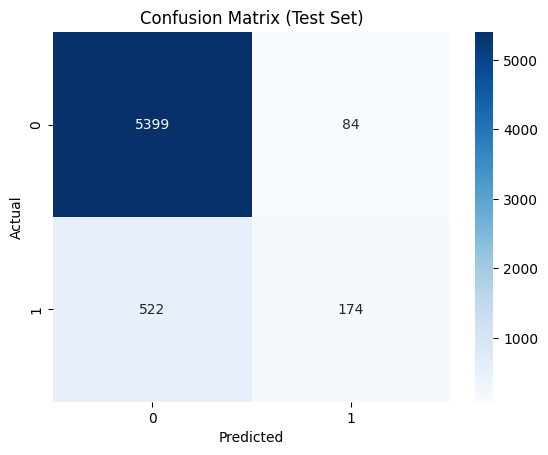

In [ ]:
#  Classification Report
print("\nTesting Classification Report:\n", classification_report(y_test, y_test_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Gradient Boosting

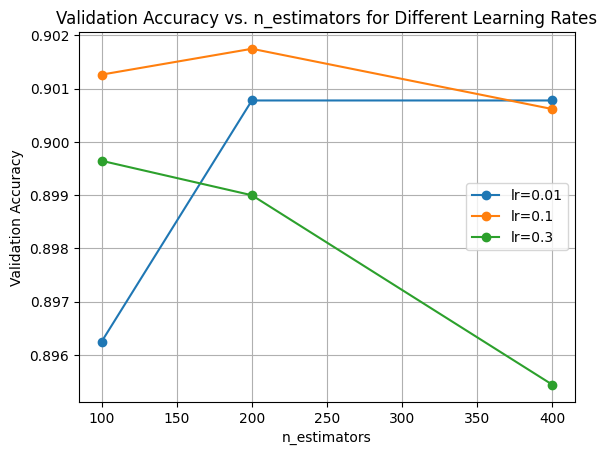

In [ ]:
# Comparing learning_rate and n_estimator parameters
learning_rates = [0.01, 0.1, 0.3]
n_estimators_list = [100, 200, 400]

train_scores, val_scores = {}, {}

for lr in learning_rates:
    train_scores[lr], val_scores[lr] = [], []
    for n_est in n_estimators_list:
        gb = GradientBoostingClassifier(
            learning_rate=lr,
            n_estimators=n_est,
            max_depth=3,
            subsample=0.8,
            random_state=42
        )
        gb.fit(X_train, y_train)
        train_scores[lr].append(gb.score(X_train, y_train))
        val_scores[lr].append(gb.score(X_valid, y_valid))

    plt.plot(n_estimators_list, val_scores[lr], marker='o', label=f'lr={lr}')

# Plot results
plt.title('Validation Accuracy vs. n_estimators for Different Learning Rates')
plt.xlabel('n_estimators')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


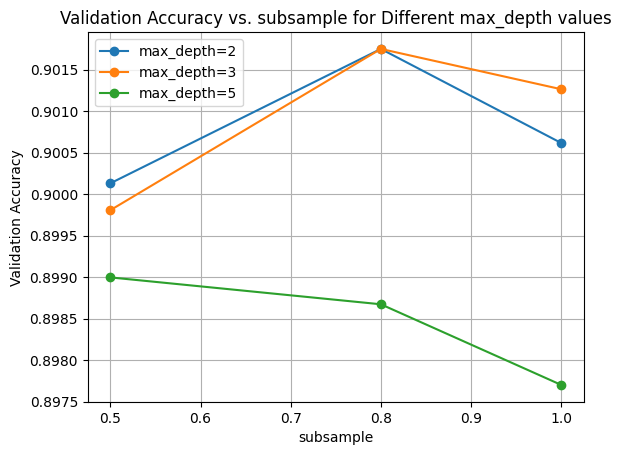

In [ ]:
# Comparing max_depth and subsample parameters
max_depths = [2, 3, 5]
subsamples = [0.5, 0.8, 1.0]

train_scores, val_scores = {}, {}

for depth in max_depths:
    train_scores[depth], val_scores[depth] = [], []
    for subsample in subsamples:
        gb = GradientBoostingClassifier(
            learning_rate=0.1,
            n_estimators=200,
            max_depth=depth,
            subsample=subsample,
            random_state=42
        )
        gb.fit(X_train, y_train)
        train_scores[depth].append(gb.score(X_train, y_train))
        val_scores[depth].append(gb.score(X_valid, y_valid))

    plt.plot(subsamples, val_scores[depth], marker='o', label=f'max_depth={depth}')

# Plot results
plt.title('Validation Accuracy vs. subsample for Different max_depth values')
plt.xlabel('subsample')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Finding best parameters for learning_rate, n_estimators, max_depth, subsample
learning_rates = [0.01, 0.1, 0.3]
n_estimators_list = [100, 200]
max_depths = [2, 3]
subsamples = [0.8, 1]

results = []

# Loop through all parameter combinations
for lr, n_est, depth, subsample in itertools.product(
    learning_rates, n_estimators_list, max_depths, subsamples
):
    gb = GradientBoostingClassifier(
        learning_rate=lr,
        n_estimators=n_est,
        max_depth=depth,
        subsample=subsample,
        random_state=42
    )
    gb.fit(X_train, y_train)

    y_valid_pred = gb.predict(X_valid)

    train_acc = gb.score(X_train, y_train)
    val_acc = gb.score(X_valid, y_valid)
    val_recall = recall_score(y_valid, y_valid_pred, pos_label=1)
    val_f1 = f1_score(y_valid, y_valid_pred, pos_label=1)
    results.append({
        'learning_rate': lr,
        'n_estimators': n_est,
        'max_depth': depth,
        'subsample': subsample,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'val_recall': val_recall,
        'val_f1': val_f1
    })

df_results = pd.DataFrame(results)
df_results

,learning_rate,n_estimators,max_depth,subsample,train_acc,val_acc,val_recall,val_f1
0,0.01,100,2,0.8,0.887343,0.887342,0.000000,0.000000
1,0.01,100,2,1.0,0.887343,0.887342,0.000000,0.000000
2,0.01,100,3,0.8,0.895807,0.896245,0.091954,0.166450
3,0.01,100,3,1.0,0.894627,0.895435,0.083333,0.152231
4,0.01,200,2,0.8,0.898998,0.900453,0.175287,0.284051
5,0.01,200,2,1.0,0.898963,0.900453,0.175287,0.284051
6,0.01,200,3,0.8,0.899830,0.900777,0.166667,0.274556
7,0.01,200,3,1.0,0.899795,0.901101,0.165230,0.273484
8,0.10,100,2,0.8,0.902119,0.901586,0.219828,0.334792
9,0.10,100,2,1.0,0.901426,0.899806,0.206897,0.317530


Train Accuracy: 0.9108598383684229
Validation Accuracy: 0.9022337325995468
Test Accuracy: 0.8994983006959055

Testing Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.95      5483
           1       0.64      0.25      0.36       696

    accuracy                           0.90      6179
   macro avg       0.77      0.62      0.65      6179
weighted avg       0.88      0.90      0.88      6179



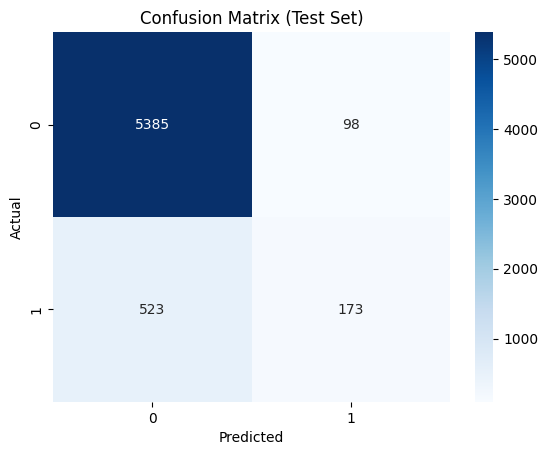

In [ ]:
# Use best parameters to train final Gradient Boosting model
gb = GradientBoostingClassifier(
    learning_rate=0.3,
    n_estimators=100,
    max_depth=3,
    subsample=1.0,
    random_state=42
)

# Train the final model
gb.fit(X_train, y_train)

# Predict
y_train_pred = gb.predict(X_train)
y_valid_pred = gb.predict(X_valid)
y_test_pred = gb.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation Accuracy:", accuracy_score(y_valid, y_valid_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

#  Classification Report
print("\nTesting Classification Report:\n", classification_report(y_test, y_test_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### XGBoost

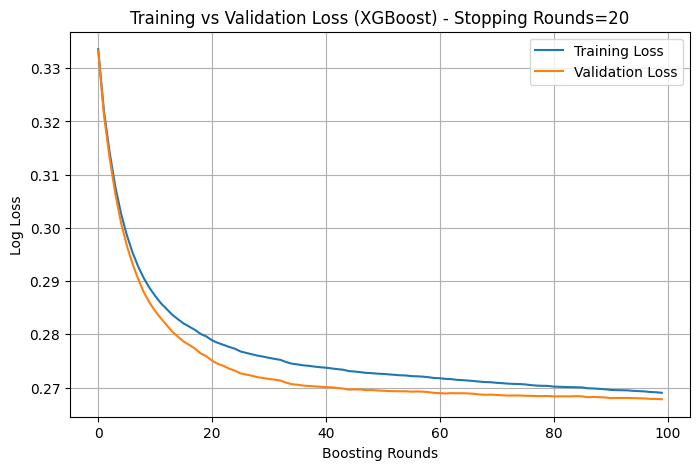

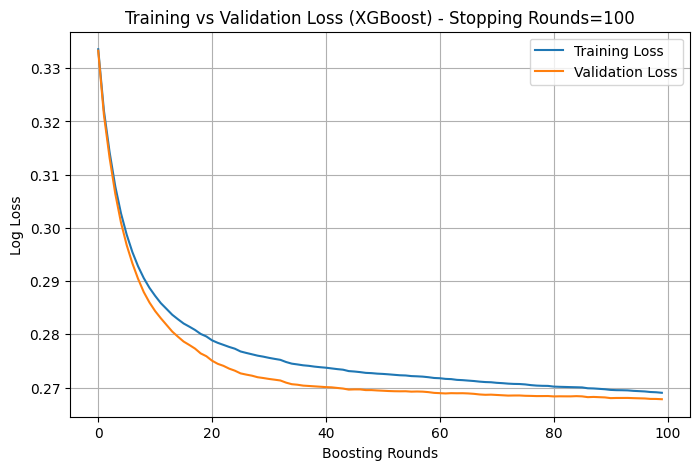

In [ ]:
# XGBoost: Finding best early_stopping_rounds parameter
for stopping_rounds in [20, 100]:
  xgb = XGBClassifier(
      learning_rate=0.1,
      n_estimators=100,
      max_depth=3,
      subsample=1,
      colsample_bytree=0.8,
      eval_metric='logloss',
      random_state=42,
      early_stopping_rounds=stopping_rounds
  )

  eval_set = [(X_train, y_train), (X_valid, y_valid)]
  xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)

  results = xgb.evals_result()

  plt.figure(figsize=(8,5))
  plt.plot(results['validation_0']['logloss'], label='Training Loss')
  plt.plot(results['validation_1']['logloss'], label='Validation Loss')
  plt.xlabel('Boosting Rounds')
  plt.ylabel('Log Loss')
  plt.title('Training vs Validation Loss (XGBoost) - Stopping Rounds='+str(stopping_rounds))
  plt.legend()
  plt.grid(True)
  plt.show()

<Figure size 800x600 with 0 Axes>

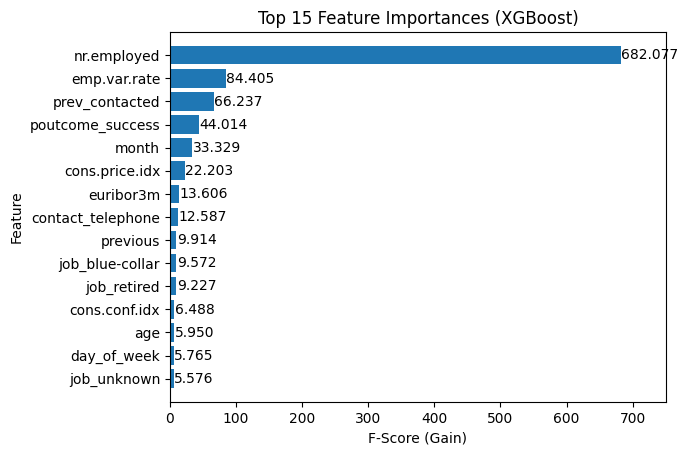

In [ ]:
# XGBoost with early_stopping_rounds=20
xgb = XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=3,
    subsample=1,
    eval_metric='logloss',
    random_state=42,
    early_stopping_rounds=20
)

eval_set = [(X_train, y_train), (X_valid, y_valid)]
xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# Feature importance
plt.figure(figsize=(8,6))
ax=plot_importance(xgb, importance_type='gain', max_num_features=15, height=0.8)
plt.title('Top 15 Feature Importances (XGBoost)')
plt.xlabel('F-Score (Gain)')
plt.ylabel('Feature')
plt.grid(False)

# Round the text labels on the bars to 3 decimal places
for text in ax.texts:
  val = float(text.get_text())
  text.set_text(f"{val:.3f}")

plt.show()

In [ ]:
# Finding best parameters for learning_rate, max_depth
learning_rates = [0.01, 0.1, 0.3]
max_depths = [2, 4, 6]

results = []

for lr in learning_rates:
    for depth in max_depths:
        xgb = XGBClassifier(
            learning_rate=lr,
            n_estimators=300,
            max_depth=depth,
            subsample=0.8,
            random_state=42,
            eval_metric='logloss'
        )

        xgb.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)

        y_pred_valid = xgb.predict(X_valid)
        train_acc = accuracy_score(y_train, xgb.predict(X_train))
        val_acc = accuracy_score(y_valid, xgb.predict(X_valid))
        val_f1 = f1_score(y_valid, y_pred_valid)
        results.append((lr, depth, train_acc, val_acc, val_f1))

df_results = pd.DataFrame(results, columns=['learning_rate', 'max_depth', 'train_acc', 'val_acc', 'val_f1'])
df_results

,learning_rate,max_depth,train_acc,val_acc,val_f1
0,0.01,2,0.899032,0.900129,0.283391
1,0.01,4,0.902015,0.901586,0.304348
2,0.01,6,0.908571,0.901263,0.342672
3,0.10,2,0.903680,0.899644,0.337607
4,0.10,4,0.914883,0.899482,0.365679
5,0.10,6,0.933960,0.899482,0.388177
6,0.30,2,0.906940,0.899806,0.365128
7,0.30,4,0.926433,0.896083,0.377907
8,0.30,6,0.956124,0.896892,0.405229


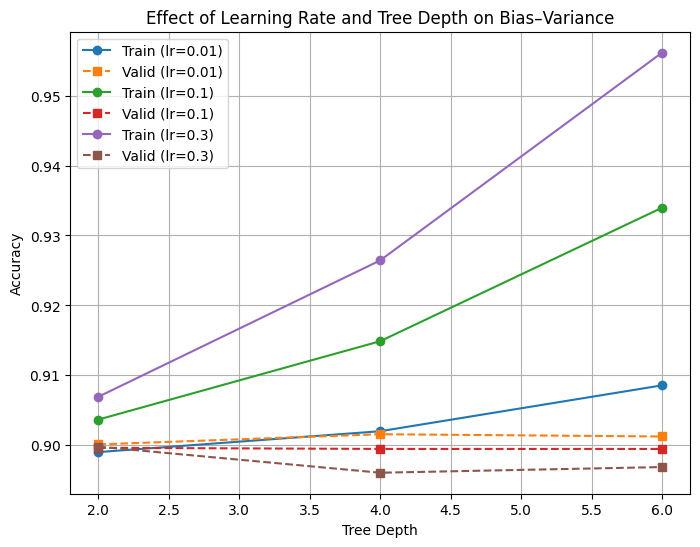

In [ ]:
plt.figure(figsize=(8,6))

for lr in learning_rates:
    subset = df_results[df_results['learning_rate'] == lr]
    plt.plot(subset['max_depth'], subset['train_acc'], marker='o', label=f'Train (lr={lr})')
    plt.plot(subset['max_depth'], subset['val_acc'], marker='s', linestyle='--', label=f'Valid (lr={lr})')

plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Effect of Learning Rate and Tree Depth on Bias–Variance')
plt.legend()
plt.grid(True)
plt.show()


XGBoost Training Time: 5.2 seconds

Train Accuracy: 0.906
Validation Accuracy 0.902
Test Accuracy 0.901

Testing Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95      5483
           1       0.68      0.23      0.35       696

    accuracy                           0.90      6179
   macro avg       0.79      0.61      0.65      6179
weighted avg       0.88      0.90      0.88      6179



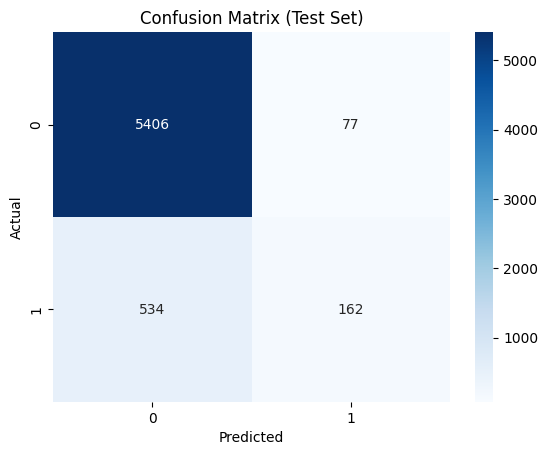

In [ ]:
# Final XGBoost model with learning_rate=0.1, max_depth=4
xgb = XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=4,
    subsample=1,
    eval_metric='logloss',
    random_state=42,
    early_stopping_rounds=20
)

# Track the training time
start_time = time.time()

eval_set = [(X_train, y_train), (X_valid, y_valid)]
xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)

end_time = time.time()
train_time = end_time - start_time

y_pred_train = xgb.predict(X_train)
y_pred_valid = xgb.predict(X_valid)
y_pred_test  = xgb.predict(X_test)

train_acc = accuracy_score(y_train, y_pred_train)
valid_acc = accuracy_score(y_valid, y_pred_valid)
test_acc  = accuracy_score(y_test, y_pred_test)

print("\nXGBoost Training Time:", round(train_time, 2), "seconds")

print("\nTrain Accuracy:",round(train_acc,3))
print("Validation Accuracy",round(valid_acc,3))
print("Test Accuracy",round(test_acc,3))

# Classification report
print("\nTesting Classification Report:\n", classification_report(y_test, y_pred_test))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### LightGBM

In [ ]:
# LightGBM: Find the best parameters for learning_rate, num_leaves, n_estimators
from lightgbm import LGBMClassifier, log_evaluation, early_stopping

learning_rates = [0.01, 0.05, 0.1, 0.3]
num_leaves_list = [15, 31, 63, 127]
n_estimators_list = [100,200,400]

results = []

for lr in learning_rates:
    for nl in num_leaves_list:
      for n_est in n_estimators_list:
          lgb = LGBMClassifier(
              learning_rate=lr,
              n_estimators=n_est,
              num_leaves=nl,
              subsample=1,
              random_state=42,
              verbose=-1
          )

          # Fit model with early stopping and no logs
          lgb.fit(
              X_train, y_train,
              eval_set=[(X_valid, y_valid)],
              eval_metric='logloss',
              callbacks=[early_stopping(stopping_rounds=20, verbose=False), log_evaluation(period=0),]
          )

          # Predictions
          y_pred_valid = lgb.predict(X_valid)
          val_acc = accuracy_score(y_valid, y_pred_valid)
          val_f1 = f1_score(y_valid, y_pred_valid)

          results.append({
              'learning_rate': lr,
              'num_leaves': nl,
              'n_estimators': n_est,
              'val_accuracy': val_acc,
              'val_f1': val_f1
          })

df_results = pd.DataFrame(results).sort_values(by='val_f1', ascending=False)
display(df_results)

# Identify best parameters
best_params = df_results.iloc[0]
print(f"Best Parameters → learning_rate={best_params['learning_rate']},num_leaves={int(best_params['num_leaves'])},n_estimators={int(best_params['n_estimators'])}")
print(f"Validation Accuracy={best_params['val_accuracy']:.3f}, F1 Score={best_params['val_f1']:.3f}")


,learning_rate,num_leaves,n_estimators,val_accuracy,val_f1
23,0.05,127,400,0.902881,0.383984
21,0.05,127,100,0.902881,0.383984
22,0.05,127,200,0.902881,0.383984
11,0.01,127,400,0.902234,0.381148
42,0.30,63,100,0.901424,0.379205
44,0.30,63,400,0.901424,0.379205
43,0.30,63,200,0.901424,0.379205
39,0.30,31,100,0.901586,0.375770
41,0.30,31,400,0.901586,0.375770
40,0.30,31,200,0.901586,0.375770


Best Parameters → learning_rate=0.05,num_leaves=127,n_estimators=400
Validation Accuracy=0.903, F1 Score=0.384


In [ ]:
# Final XGBoost model with learning_rate=0.05, num_leaves=127, n_estimators=400
lgb = LGBMClassifier(
    learning_rate=0.05,
    n_estimators=400,
    num_leaves=127,
    subsample=1,
    random_state=42,
    verbose=-1
)

# Track the training time
start_time = time.time()

# Fit model with early stopping and no logs
lgb.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='logloss',
    callbacks=[early_stopping(stopping_rounds=20,verbose=False)]
)

end_time = time.time()
train_time = end_time - start_time

y_pred_train = lgb.predict(X_train)
y_pred_valid = lgb.predict(X_valid)
y_pred_test  = lgb.predict(X_test)

print("\nLightGBM Training Time:", round(train_time, 2), "seconds")

print("\nTrain Accuracy:",round(accuracy_score(y_train, y_pred_train),3))
print("Validation Accuracy",round(accuracy_score(y_valid, y_pred_valid),3))
print("Test Accuracy",round(accuracy_score(y_test,  y_pred_test),3))


LightGBM Training Time: 0.74 seconds

Train Accuracy: 0.916
Validation Accuracy 0.903
Test Accuracy 0.902



Testing Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.95      5483
           1       0.67      0.25      0.36       696

    accuracy                           0.90      6179
   macro avg       0.79      0.62      0.65      6179
weighted avg       0.88      0.90      0.88      6179



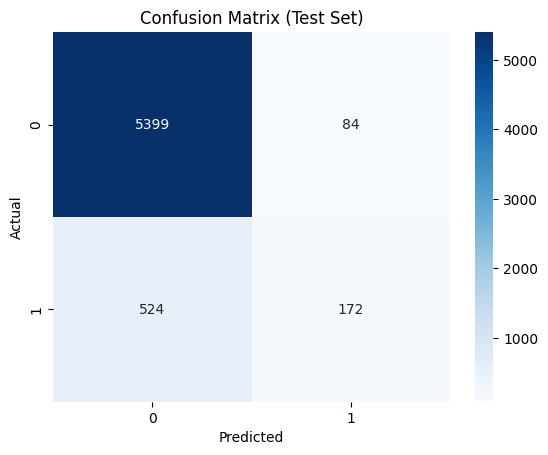

In [ ]:
# Classification report
print("\nTesting Classification Report:\n", classification_report(y_test, y_pred_test))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Model Comparisons

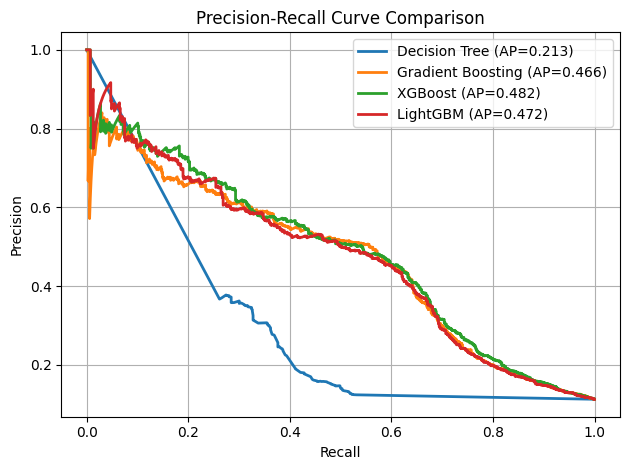

In [ ]:
# Generate predicted probabilities for the positive class
y_scores_dt = dt.predict_proba(X_test)[:, 1]
y_scores_gb   = gb.predict_proba(X_test)[:, 1]
y_scores_xgb  = xgb.predict_proba(X_test)[:, 1]
y_scores_lgb  = lgb.predict_proba(X_test)[:, 1]

# Compute precision, recall, and average precision
prec_dt, rec_dt, _ = precision_recall_curve(y_test, y_scores_dt)
prec_gb, rec_gb, _     = precision_recall_curve(y_test, y_scores_gb)
prec_xgb, rec_xgb, _   = precision_recall_curve(y_test, y_scores_xgb)
prec_lgb, rec_lgb, _   = precision_recall_curve(y_test, y_scores_lgb)

ap_dt = average_precision_score(y_test, y_scores_dt)
ap_gb   = average_precision_score(y_test, y_scores_gb)
ap_xgb  = average_precision_score(y_test, y_scores_xgb)
ap_lgb  = average_precision_score(y_test, y_scores_lgb)

# Plot all curves
plt.plot(rec_dt, prec_dt, label=f"Decision Tree (AP={ap_dt:.3f})", linewidth=2)
plt.plot(rec_gb, prec_gb, label=f"Gradient Boosting (AP={ap_gb:.3f})", linewidth=2)
plt.plot(rec_xgb, prec_xgb, label=f"XGBoost (AP={ap_xgb:.3f})", linewidth=2)
plt.plot(rec_lgb, prec_lgb, label=f"LightGBM (AP={ap_lgb:.3f})", linewidth=2)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
